            Timestamp   Price
Timestamp                    
1990-12-19 1990-12-19   99.98
1990-12-20 1990-12-20  104.39
1990-12-21 1990-12-21  109.13
1990-12-24 1990-12-24  114.55
1990-12-25 1990-12-25  120.25
                               Timestamp        Price
Timestamp                                            
1990-12-31 1990-12-24 13:20:00.000000000   116.990000
1991-01-31 1991-01-16 16:21:49.090909056   132.628182
1991-02-28 1991-02-14 22:40:00.000000000   131.887778
1991-03-31 1991-03-15 18:17:08.571428608   126.011429
1991-04-30 1991-04-14 22:54:32.727272704   118.426818
...                                  ...          ...
2019-11-30 2019-11-15 18:17:08.571428608  2923.774700
2019-12-31 2019-12-15 22:54:32.727272704  2962.063709
2020-01-31 2020-01-12 21:00:00.000000000  3078.654681
2020-02-29 2020-02-15 12:00:00.000000000  2927.513035
2020-03-31 2020-03-06 21:20:00.000000000  2990.415289

[352 rows x 2 columns]


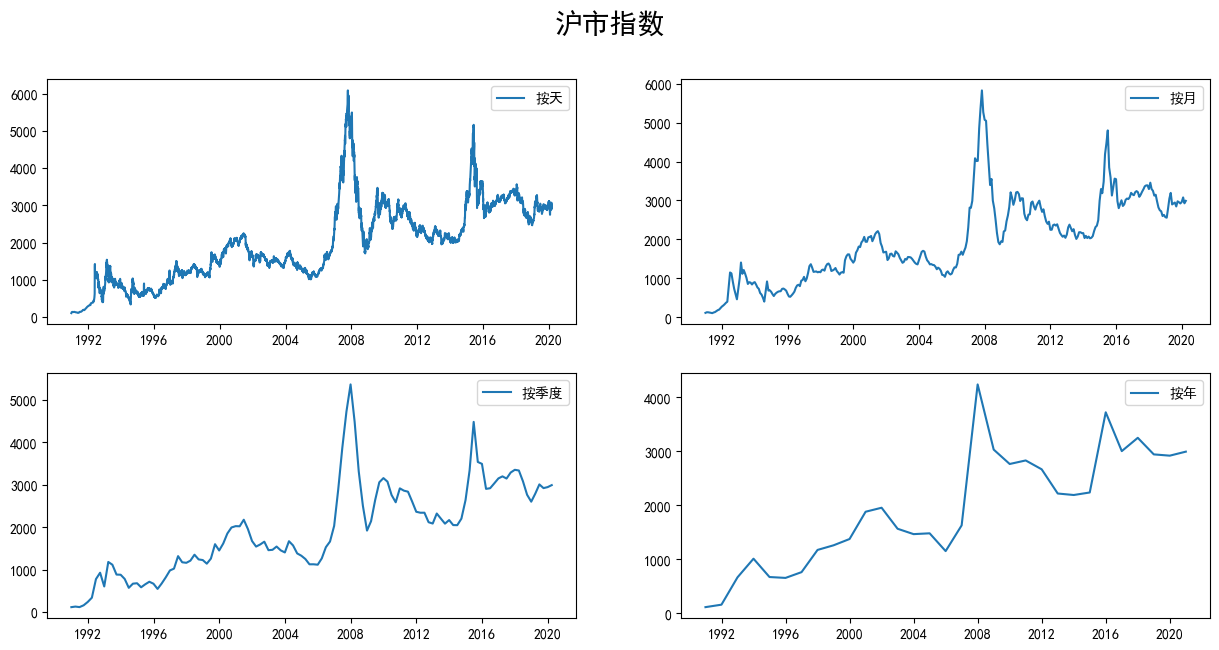

最优模型:                                 SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  352
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2290.955
Date:                Sat, 05 Apr 2025   AIC                           4593.911
Time:                        19:59:36   BIC                           4617.092
Sample:                    12-31-1990   HQIC                          4603.136
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1962.7852    466.521      4.207      0.000    1048.422    2877.149
ar.L1          0.4820      0.123      3.905      0.000       0.240       0.724
ar.L2          0.4831      0.122      3.947  

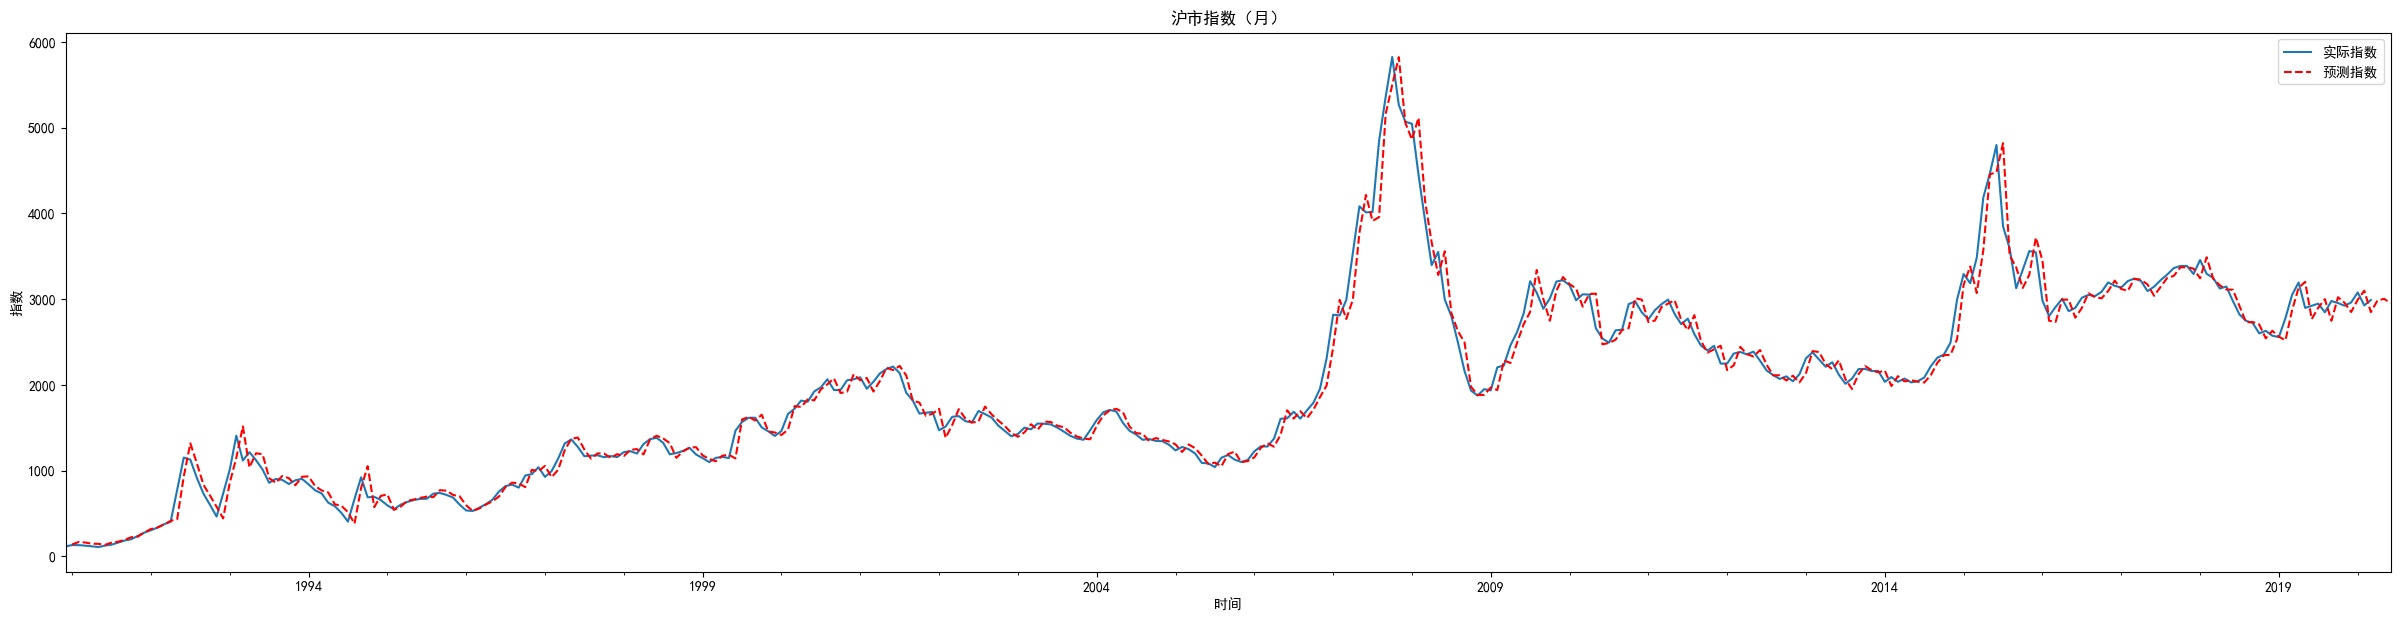

In [1]:
# -*- coding: utf-8 -*-
# 沪市指数走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')
# 数据加载
df = pd.read_csv('./shanghai_index_1990_12_19_to_2020_03_12.csv')
df = df[['Timestamp', 'Price']]

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)
#print(df_Q)
#print(df_year)

# 按照天，月，季度，年来显示沪市指数的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('沪市指数', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

# 设置参数范围
ps = range(0, 3) #0, 1, 2
qs = range(0, 3) #0, 1, 2
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
        model = ARIMA(df_month.Price,order=(param[0], 0, param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    # 打擂法
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN
print(df_month2)

# 沪市指数预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()


In [5]:
#df_month.Price
#help(ARMA)